In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import figure

In [2]:
earliest_mouse_age = 21  # days


def age(s):
    return ((s - s.min()).dt.days + earliest_mouse_age) / 7


def load_long_df(version=4, df_version=0):
    df = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_syllable_df_v{df_version:02d}.parquet"
    )
    df = relabel_by_usage(df, return_map=False)
    df["mouse_id"] = df["subject_name"].str[:5]
    df = df[~df["mouse_id"].str.lower().str.contains("c")]
    df = df[~df["mouse_id"].str.lower().str.contains("long")]
    ages = df.groupby("mouse_id", sort=False)['date'].transform(age)
    df["age"] = ages

    session_length = df.groupby("uuid")["timestamps"].max()
    remove_uuids = session_length[session_length < 600].index
    df = df[~df["uuid"].isin(remove_uuids)]

    usage_df = (
        df.query("onsets")
        .groupby(["age", "mouse_id", "uuid"])["relabeled_syllables"]
        .value_counts(normalize=True)
    )
    usage_df.name = "usage"
    usage_df = usage_df.reset_index()
    usage_mtx = usage_df.pivot_table(
        values="usage", columns="relabeled_syllables", index=["age", "mouse_id", "uuid"]
    ).fillna(0)

    # remove sessions with abnormally high syllable usage
    usage_mtx = usage_mtx[~(usage_mtx > 0.15).any(axis=1)]

    # remove sessions with abnormally few syllables used
    usage_mtx = usage_mtx[(usage_mtx > 0).sum(axis=1) > 20]
    return usage_mtx.drop('05_02', level='mouse_id')

In [3]:
df = load_long_df()

## K-NN regressor

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, StratifiedGroupKFold, ShuffleSplit, RepeatedStratifiedKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [5]:
from scipy.spatial.distance import jensenshannon

In [6]:
mdl = KNeighborsRegressor(n_neighbors=20, weights='distance')

In [7]:
age_bins = pd.qcut(df.index.get_level_values('age'), 37, labels=False)

In [8]:
pipeline = make_pipeline(
    # StandardScaler(),
    # PCA(n_components=40),
    KNeighborsRegressor(n_neighbors=13, weights='distance', p=2, leaf_size=30),
)

# score = cross_val_score(pipeline, df, y=df.index.get_level_values('age'), groups=df.index.get_level_values('mouse_id'), cv=LeaveOneGroupOut())
# score = cross_val_score(pipeline, df, y=age_bins, groups=df.index.get_level_values('mouse_id'), cv=StratifiedGroupKFold(n_splits=10))
# score = cross_val_score(pipeline, df, y=age_bins, groups=df.index.get_level_values('mouse_id'), cv=GroupShuffleSplit(n_splits=7))
# score = cross_val_score(pipeline, df, y=age_bins, groups=df.index.get_level_values('mouse_id'), cv=StratifiedKFold(n_splits=10))
score = cross_val_score(pipeline, df, y=age_bins, groups=df.index.get_level_values('mouse_id'), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=100))

In [9]:
# df.index.get_level_values('mouse_id').unique()[np.argsort(score)]

In [10]:
# np.sort(score)

In [11]:
np.mean(score)

0.8936023365628607

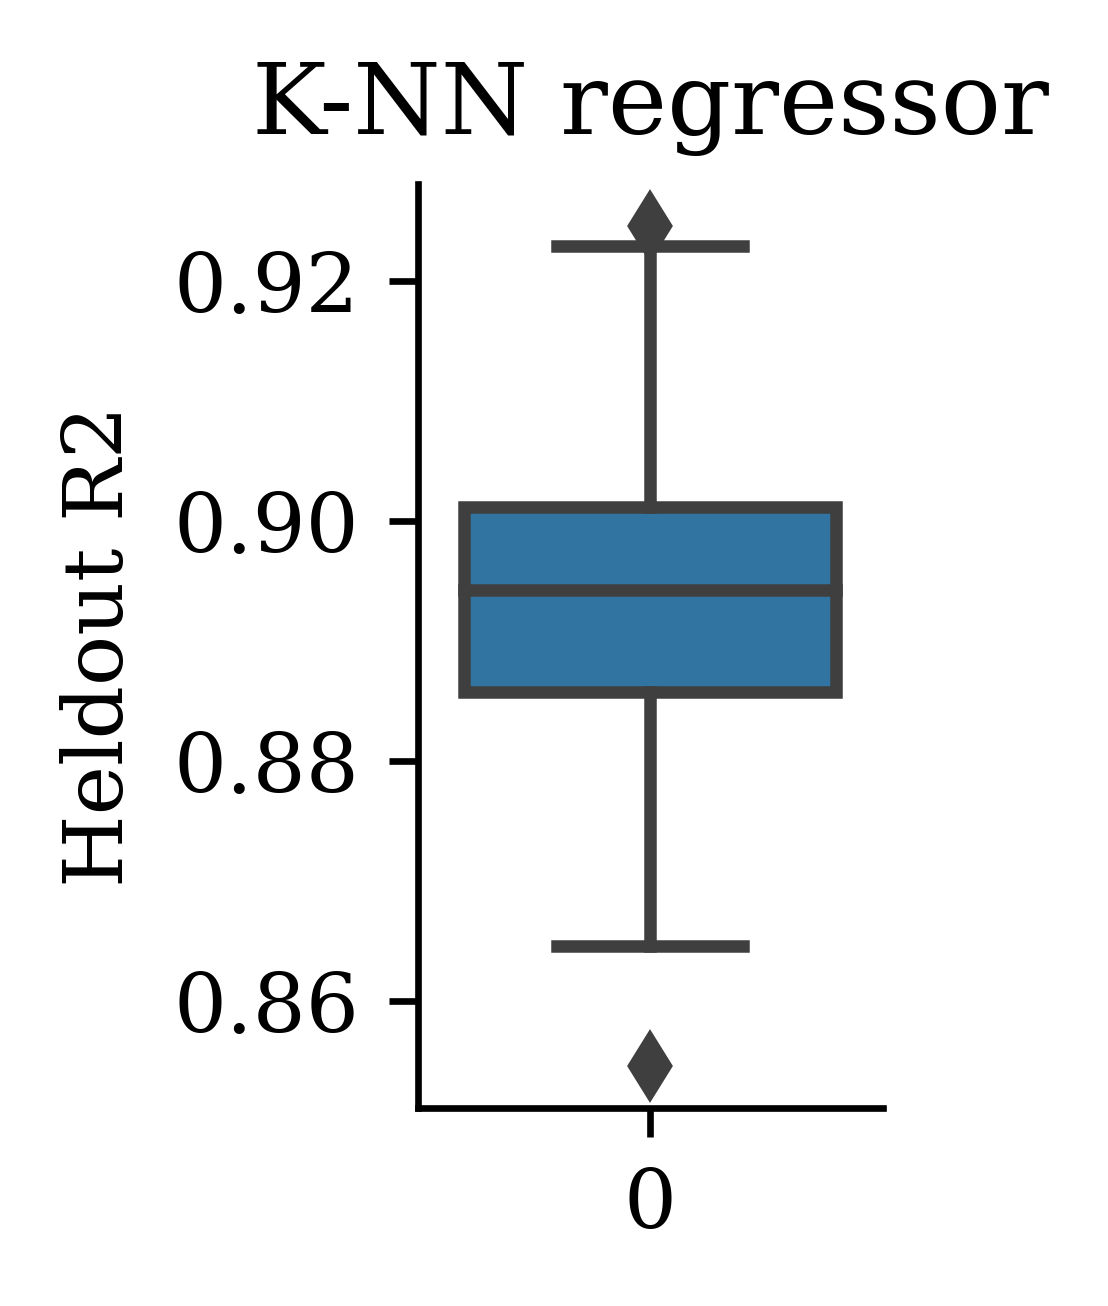

In [14]:
figure(1, 2)
ax = sns.boxplot(score)
ax.set(ylabel='Heldout R2', title='K-NN regressor')
sns.despine()